In [1]:
%matplotlib inline
import skimage.io as skm
import numpy as np
from PIL import Image

In [2]:
from skimage import img_as_float

In [3]:
image0 = skm.imread('png/00.png')
image1 = skm.imread('png/01.png')
image2 = skm.imread('png/02.png')
image3 = skm.imread('png/03.png')
image4 = skm.imread('png/04.png')
image5 = skm.imread('png/05.png')
image6 = skm.imread('png/06.png')
image7 = skm.imread('png/07.png')
image8 = skm.imread('png/08.png')
image9 = skm.imread('png/09.png')

In [5]:
def show(im):
    return Image.fromarray(im)

In [6]:
image9.shape

(1155, 444)

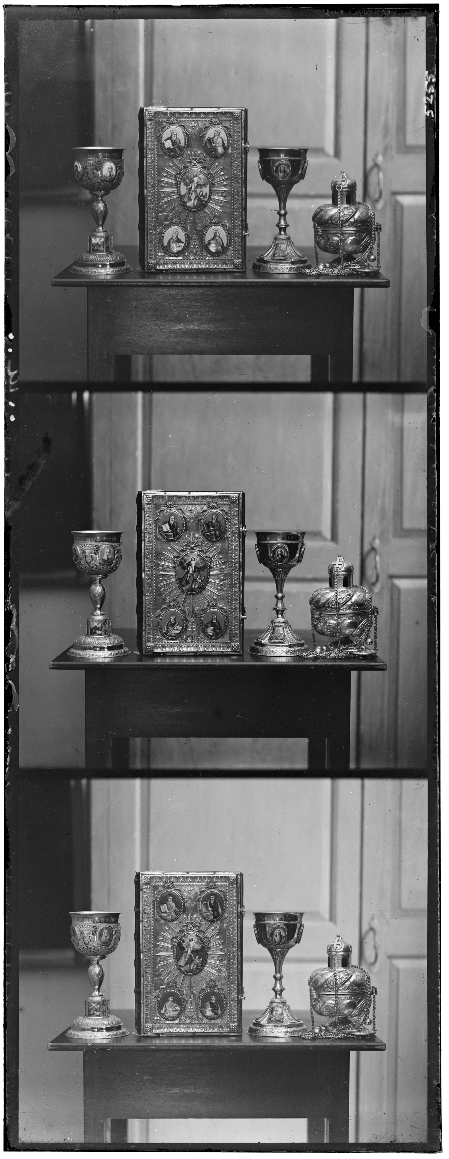

In [7]:
show(image5)

In [8]:
def cut(image, h = 0.05, v=0.05):
    image = image.copy()
    h_slice = (int(image.shape[0]*h),int(image.shape[0]*(1-h)))
    v_slice = (int(image.shape[1]*v),int(image.shape[1]*(1-v))) 
    image = image[h_slice[0]:h_slice[1],v_slice[0]:v_slice[1]]
    return image

In [9]:
def g_b_r(image):
    indexes = np.array([np.arange(0,image.shape[0]),np.arange(0,image.shape[1])])
    image = cut(image, h = 0)
    
    indexes[1] = indexes[1][int(indexes[1].shape[0]*0.05):int(indexes[1].shape[0]*0.95)] 
    
    b = cut(image[0:image.shape[0]//3], v = 0)
    b_ind = np.array([indexes[0][0:image.shape[0]//3],indexes[1]])
    b_ind[0] = b_ind[0][int(b_ind[0].shape[0]*0.05):int(b_ind[0].shape[0]*0.95)] 
    
    g = cut(image[image.shape[0]//3:int(image.shape[0]/3*2)], v=0)
    g_ind = np.array([indexes[0][image.shape[0]//3:int(image.shape[0]/3*2)],indexes[1]])
    g_ind[0] = g_ind[0][int(g_ind[0].shape[0]*0.05):int(g_ind[0].shape[0]*0.95)] 
    
    r = cut(image[image.shape[0]//3*2:image.shape[0]//3*3], v=0)
    r_ind = np.array([indexes[0][image.shape[0]//3*2:image.shape[0]],indexes[1]])
    r_ind[0] = r_ind[0][int(r_ind[0].shape[0]*0.05):int(r_ind[0].shape[0]*0.95)]
    
    '''
    if r.shape > g.shape:
        r = r[0:g.shape[0],0:g.shape[1]]
    elif r.shape < g.shape:
        g = g[0:r.shape[0],0:r.shape[1]]
        b = b[0:r.shape[0],0:r.shape[1]]
    if b.shape > g.shape:
        b = b[0:g.shape[0],0:g.shape[1]] 
    elif b.shape < g.shape:
        g = g[0:b.shape[0],0:b.shape[1]]
        r = r[0:b.shape[0],0:b.shape[1]]
    '''
    
    return {'g':g,'b':b,'r':r, 'g_ind':g_ind,'b_ind':b_ind,'r_ind':r_ind,}

In [10]:
def shifter_corr(static_im, shift_im, iter=15):
    max_corr = 0
    for col_shift in range(-iter,iter+1):
        for row_shift in range(-iter,iter+1):
            roll_im = np.roll(np.roll(shift_im, col_shift, axis=1), row_shift, axis=0) #сдвигаем по колонкам, потом по строкам
            corr = (img_as_float(roll_im)*img_as_float(static_im)).sum() #и считаем корелляцию
            if corr > max_corr:
                row= row_shift #записываем сдвиги по горизонтали и вертикали, если нашли максимальную корелляцию
                col = col_shift
                max_corr = corr.copy() 
    return {'row':row,'col':col} 

In [11]:
def align(img, g_coord, itr = 15):
    row_g, col_g = g_coord
    gbr = g_b_r(img)
    g = gbr['g']
    b = gbr['b']
    r = gbr['r']   
    ind_row = list(gbr['g_ind'][0]).index(row_g)
    ind_col = list(gbr['g_ind'][1]).index(col_g)  
    g_b_shift = shifter_corr(g, b, itr)
    g_r_shift = shifter_corr(g, r, itr)   
    row_b = gbr['b_ind'][0][ind_row] + g_b_shift['row']
    col_b = gbr['b_ind'][1][ind_col] + g_b_shift['col']   
    row_r = gbr['r_ind'][0][ind_row] + g_r_shift['row']
    col_r = gbr['r_ind'][1][ind_col] + g_r_shift['col']   
    return (row_b, col_b), (row_r, col_r)

In [12]:
def align_im(img, itr = 15):
    g = g_b_r(img)['g']
    b = g_b_r(img)['b']
    r = g_b_r(img)['r']
    g_b_shift = shifter_corr(g, b, itr)
    g_r_shift = shifter_corr(g, r, itr)
    b_shifted = np.roll(np.roll(b, g_b_shift['col'], axis=1), g_b_shift['row'], axis=0)
    r_shifted = np.roll(np.roll(r, g_r_shift['col'], axis=1), g_r_shift['row'], axis=0)
    return np.dstack((r_shifted, g, b_shifted))

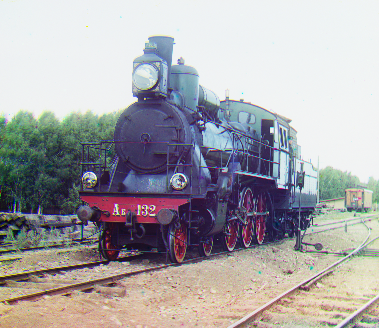

In [13]:
show(cut(align_im(image3),0.03,0.03))

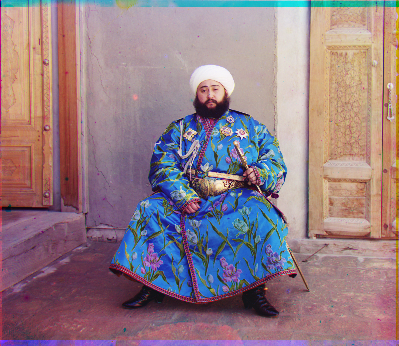

In [17]:
show(align_im(image9))

In [542]:
Image.fromarray(cut(align_im(image3),0.03,0.03)).save('D:/PARAVOZIK.jpeg','JPEG')

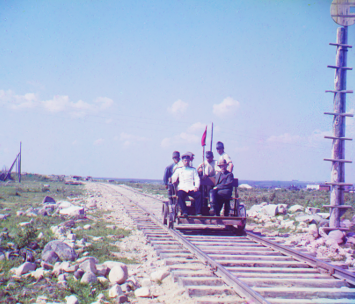

In [534]:
show(cut(align_im(image0, itr = 20),0.03,0.03))

In [540]:
align(image0, (508,237), 0)

((150, 237), (866, 237))

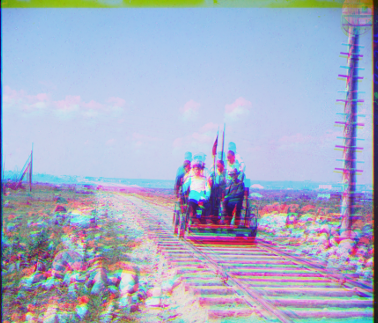

In [541]:
show(np.dstack((g_b_r(image0)['r'],g_b_r(image0)['g'],g_b_r(image0)['b'])))